# LSTM

### Processor
* VOC_duration : 1min
* Wash_Out : 8min

### Sensors
+ TGS : TGS2600, TGS2602, TGS2603, TGS2610, TGS2620
+ MQ : MQ2, MQ3, MQ4, MQ5, MQ6, MQ7, MQ8, MQ9, MQ135

### VOC
1. DPG ( 10%) + DPG (100%)
2. Actetic (10%) + DPG (99%)
3. Benzaldehyde (10%) + DPG (99%)
4. Keras (10%) + DPG (99%)

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymysql
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
from matplotlib.colors import ListedColormap

import os, sys
from pathlib import Path
from tqdm import tqdm
from datetime import datetime, timedelta
import datetime, time

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import statsmodels.api as sm
from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM
import tensorflow.keras.backend as K

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K
import keras

import graphviz

In [3]:
import warnings
warnings.filterwarnings(action='ignore')

plot_style = plt.style.available
# plt.style.use('ggplot')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-paper')
# plt.style.use('seaborn-muted')

# pd.options.display.float_format = '{:.5f}'.format
# pd.set_option('display.max_row', 500)
pd.set_option('display.max_rows', 500)

pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [4]:
PROJECT_DIR = Path('.')
CSV_DIR = Path(PROJECT_DIR, 'csv')
DATA_DIR = Path(PROJECT_DIR, 'data')
RESULT_DIR = Path(PROJECT_DIR, 'results')
NPY_DIR = Path(PROJECT_DIR, 'data', 'npy')
HDF_DIR = Path(PROJECT_DIR, 'data', 'hdf')

## LSTM

### Check of CPU/GPU status

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


2024-03-20 01:12:41.080656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-20 01:12:41.089438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-20 01:12:41.089792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Data read (1-sec)

In [6]:
# with pd.HDFStore(HDF_DIR/'1_sec_data.h5') as store:
#     print(store.info())
#     df_01 = store['/drug/tgs_sensers/1sec_mean']

df_01 = pd.read_hdf(HDF_DIR/'1_sec_data.h5', '/30sec/X_sensor')
df_01.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21840 entries, ('Acetic_001', Timestamp('2023-05-07 03:44:03')) to ('Keras_725', Timestamp('2023-05-11 17:49:10'))
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TGS2600  21840 non-null  float64
 1   TGS2602  21840 non-null  float64
 2   TGS2603  21840 non-null  float64
 3   TGS2620  21840 non-null  float64
 4   TGS2610  21840 non-null  float64
 5   TGS822   21840 non-null  float64
dtypes: float64(6)
memory usage: 1.8+ MB


In [7]:
df = df_01.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21840 entries, ('Acetic_001', Timestamp('2023-05-07 03:44:03')) to ('Keras_725', Timestamp('2023-05-11 17:49:10'))
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TGS2600  21840 non-null  float64
 1   TGS2602  21840 non-null  float64
 2   TGS2603  21840 non-null  float64
 3   TGS2620  21840 non-null  float64
 4   TGS2610  21840 non-null  float64
 5   TGS822   21840 non-null  float64
dtypes: float64(6)
memory usage: 1.8+ MB


In [8]:
columns = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822',
           'CYCLE', 'VOC_CYCLE', 'UNIXSTAMP']
available_senosors = ['TGS2600', 'TGS2602', 'TGS2603', 'TGS2620', 'TGS2610', 'TGS822']
non_available_sensors = []

In [9]:
labels = {
    'DPG' : 0,
    'Acetic' : 1,
    'Benzaldehyde' : 2,
    'Keras' : 3
}

In [10]:
idx = pd.IndexSlice
df = df[available_senosors]
available_sensors_no = len(available_senosors)
samples = df.index.get_level_values('VOC_CYCLE').unique().tolist()

  0% 0/10 [00:00<?, ?it/s]

Epoch 1/100
3/4 [=====================>........] - ETA: 0s - loss: 1.3708 - accuracy: 0.2370
Epoch 1: val_accuracy improved from inf to 0.26984, saving model to results/lstm/lstm_30sec.h5
4/4 [==============================] - 2s 96ms/step - loss: 1.3659 - accuracy: 0.2510 - val_loss: 1.3536 - val_accuracy: 0.2698
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.3538 - accuracy: 0.2570
Epoch 2: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 61ms/step - loss: 1.3538 - accuracy: 0.2570 - val_loss: 1.3417 - val_accuracy: 0.2698
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.2849
Epoch 3: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 54ms/step - loss: 1.3383 - accuracy: 0.2849 - val_loss: 1.3289 - val_accuracy: 0.3571
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.3254 - accuracy: 0.3307
Epoch 4: val_accuracy did not improve from 0.26

4/4 [==============================] - ETA: 0s - loss: 0.5803 - accuracy: 0.7888
Epoch 30: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 61ms/step - loss: 0.5803 - accuracy: 0.7888 - val_loss: 0.4765 - val_accuracy: 0.8571
Epoch 31/100
3/4 [=====================>........] - ETA: 0s - loss: 0.5790 - accuracy: 0.7604
Epoch 31: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 54ms/step - loss: 0.5489 - accuracy: 0.7829 - val_loss: 0.4680 - val_accuracy: 0.8492
Epoch 32/100
3/4 [=====================>........] - ETA: 0s - loss: 0.5905 - accuracy: 0.7708
Epoch 32: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 54ms/step - loss: 0.5682 - accuracy: 0.7789 - val_loss: 0.4532 - val_accuracy: 0.8810
Epoch 33/100
4/4 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.8187
Epoch 33: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 64m

Epoch 60/100
4/4 [==============================] - ETA: 0s - loss: 0.4474 - accuracy: 0.8287
Epoch 60: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 57ms/step - loss: 0.4474 - accuracy: 0.8287 - val_loss: 0.3437 - val_accuracy: 0.9524
Epoch 61/100
4/4 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8446
Epoch 61: val_accuracy did not improve from 0.26984
4/4 [==============================] - 0s 6ms/step


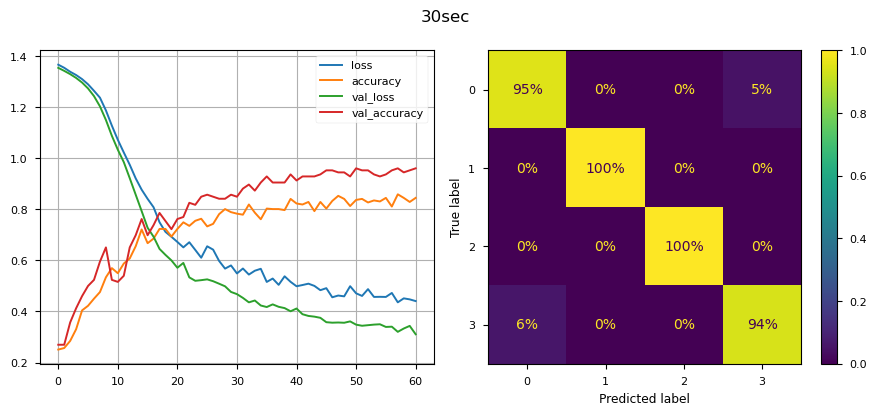

4/4 [==============================] - 0s 6ms/step - loss: 0.2689 - accuracy: 0.9700


 10% 1/10 [00:15<02:18, 15.37s/it]

Test Loss: 0.26890867948532104
Test Accuracy: 0.9700000286102295
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3656 - accuracy: 0.2510
Epoch 1: val_accuracy improved from inf to 0.51587, saving model to results/lstm/lstm_60sec.h5
4/4 [==============================] - 2s 154ms/step - loss: 1.3656 - accuracy: 0.2510 - val_loss: 1.3355 - val_accuracy: 0.5159
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.3285 - accuracy: 0.4522
Epoch 2: val_accuracy improved from 0.51587 to 0.50000, saving model to results/lstm/lstm_60sec.h5
4/4 [==============================] - 0s 97ms/step - loss: 1.3285 - accuracy: 0.4522 - val_loss: 1.3000 - val_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.2964 - accuracy: 0.4422
Epoch 3: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 123ms/step - loss: 1.2964 - accuracy: 0.4422 - val_loss: 1.2538 - val_accuracy: 0.5476
Epoch 4/100
4/4 [========

Epoch 30/100
4/4 [==============================] - ETA: 0s - loss: 0.2056 - accuracy: 0.9622
Epoch 30: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 122ms/step - loss: 0.2056 - accuracy: 0.9622 - val_loss: 0.1230 - val_accuracy: 0.9841
Epoch 31/100
4/4 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9741
Epoch 31: val_accuracy did not improve from 0.50000
4/4 [==============================] - 0s 13ms/step


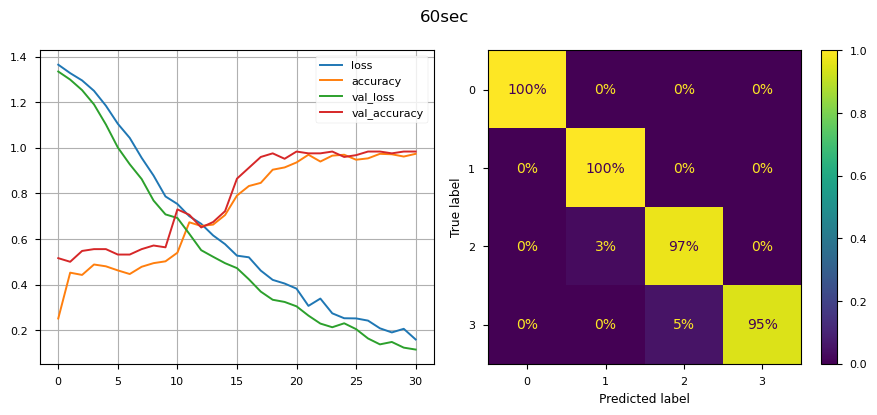

4/4 [==============================] - 0s 10ms/step - loss: 0.3876 - accuracy: 0.9800


 20% 2/10 [00:29<01:58, 14.80s/it]

Test Loss: 0.3876476287841797
Test Accuracy: 0.9800000190734863
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3750 - accuracy: 0.2834
Epoch 1: val_accuracy improved from inf to 0.23016, saving model to results/lstm/lstm_120sec.h5
4/4 [==============================] - 2s 243ms/step - loss: 1.3750 - accuracy: 0.2834 - val_loss: 1.3005 - val_accuracy: 0.2302
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.2886 - accuracy: 0.2595
Epoch 2: val_accuracy did not improve from 0.23016
4/4 [==============================] - 1s 177ms/step - loss: 1.2886 - accuracy: 0.2595 - val_loss: 1.2115 - val_accuracy: 0.2302
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.1841 - accuracy: 0.2695
Epoch 3: val_accuracy did not improve from 0.23016
4/4 [==============================] - 1s 186ms/step - loss: 1.1841 - accuracy: 0.2695 - val_loss: 1.0532 - val_accuracy: 0.3968
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.981

Epoch 30/100
4/4 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.8723
Epoch 30: val_accuracy did not improve from 0.23016
4/4 [==============================] - 1s 196ms/step - loss: 0.2883 - accuracy: 0.8723 - val_loss: 0.1943 - val_accuracy: 0.9286
Epoch 31/100
4/4 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.9321
Epoch 31: val_accuracy did not improve from 0.23016
4/4 [==============================] - 1s 187ms/step - loss: 0.2586 - accuracy: 0.9321 - val_loss: 0.1606 - val_accuracy: 1.0000
Epoch 32/100
4/4 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9800
Epoch 32: val_accuracy did not improve from 0.23016
4/4 [==============================] - 1s 171ms/step - loss: 0.2557 - accuracy: 0.9800 - val_loss: 0.1669 - val_accuracy: 1.0000
Epoch 33/100
4/4 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9900
Epoch 33: val_accuracy did not improve from 0.23016
4/4 [========================

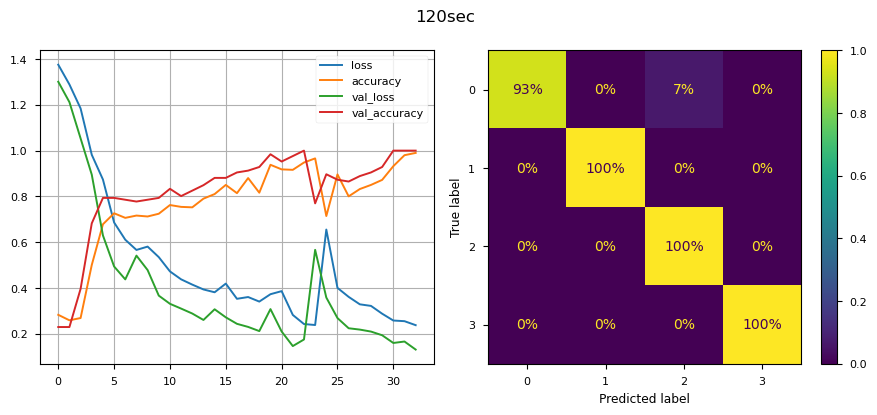

4/4 [==============================] - 0s 25ms/step - loss: 0.1899 - accuracy: 0.9800


 30% 3/10 [00:54<02:16, 19.54s/it]

Test Loss: 0.18990932404994965
Test Accuracy: 0.9800000190734863
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3556 - accuracy: 0.2495
Epoch 1: val_accuracy improved from inf to 0.42063, saving model to results/lstm/lstm_180sec.h5
4/4 [==============================] - 2s 300ms/step - loss: 1.3556 - accuracy: 0.2495 - val_loss: 1.2630 - val_accuracy: 0.4206
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.2336 - accuracy: 0.4511
Epoch 2: val_accuracy did not improve from 0.42063
4/4 [==============================] - 1s 235ms/step - loss: 1.2336 - accuracy: 0.4511 - val_loss: 1.0103 - val_accuracy: 0.5317
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.4870
Epoch 3: val_accuracy did not improve from 0.42063
4/4 [==============================] - 1s 258ms/step - loss: 0.9898 - accuracy: 0.4870 - val_loss: 0.8042 - val_accuracy: 0.5317
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 0.89

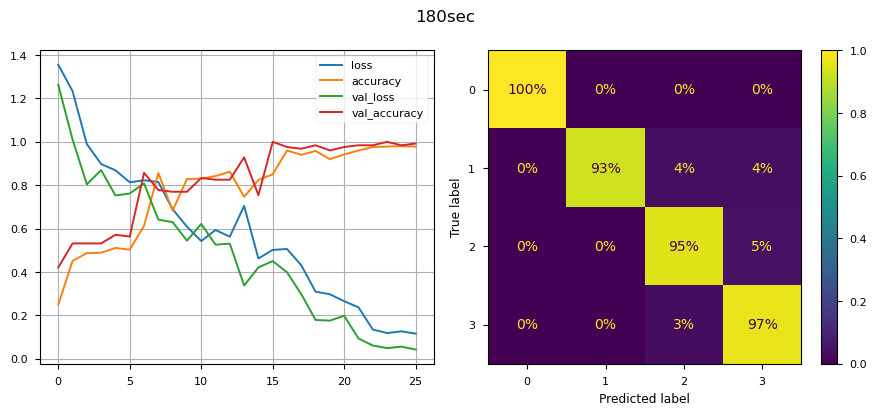

4/4 [==============================] - 0s 36ms/step - loss: 0.5149 - accuracy: 0.9600


 40% 4/10 [01:22<02:15, 22.64s/it]

Test Loss: 0.5148710608482361
Test Accuracy: 0.9599999785423279
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.2994
Epoch 1: val_accuracy improved from inf to 0.26190, saving model to results/lstm/lstm_240sec.h5
4/4 [==============================] - 3s 360ms/step - loss: 1.3637 - accuracy: 0.2994 - val_loss: 1.3196 - val_accuracy: 0.2619
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.2347 - accuracy: 0.3234
Epoch 2: val_accuracy did not improve from 0.26190
4/4 [==============================] - 1s 348ms/step - loss: 1.2347 - accuracy: 0.3234 - val_loss: 1.0928 - val_accuracy: 0.5714
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.3038 - accuracy: 0.3673
Epoch 3: val_accuracy did not improve from 0.26190
4/4 [==============================] - 1s 303ms/step - loss: 1.3038 - accuracy: 0.3673 - val_loss: 1.3407 - val_accuracy: 0.2778
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.267

Epoch 30/100
4/4 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7365
Epoch 30: val_accuracy did not improve from 0.26190
4/4 [==============================] - 1s 318ms/step - loss: 0.5568 - accuracy: 0.7365 - val_loss: 0.5802 - val_accuracy: 0.7778
Epoch 31/100
4/4 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.8703
Epoch 31: val_accuracy did not improve from 0.26190
4/4 [==============================] - 1s 320ms/step - loss: 0.5050 - accuracy: 0.8703 - val_loss: 0.5016 - val_accuracy: 0.8730
Epoch 32/100
4/4 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.8423
Epoch 32: val_accuracy did not improve from 0.26190
4/4 [==============================] - 1s 306ms/step - loss: 0.4846 - accuracy: 0.8423 - val_loss: 0.5255 - val_accuracy: 0.7857
Epoch 33/100
4/4 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.7864
Epoch 33: val_accuracy did not improve from 0.26190
4/4 [========================

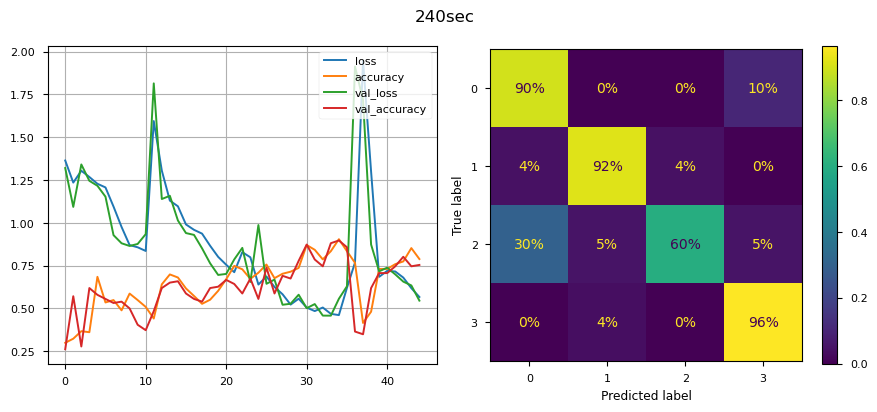

4/4 [==============================] - 0s 42ms/step - loss: 0.6537 - accuracy: 0.8600


 50% 5/10 [02:20<02:56, 35.30s/it]

Test Loss: 0.6537248492240906
Test Accuracy: 0.8600000143051147
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3707 - accuracy: 0.3174
Epoch 1: val_accuracy improved from inf to 0.47619, saving model to results/lstm/lstm_300sec.h5
4/4 [==============================] - 3s 443ms/step - loss: 1.3707 - accuracy: 0.3174 - val_loss: 1.3330 - val_accuracy: 0.4762
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.2749 - accuracy: 0.5928
Epoch 2: val_accuracy did not improve from 0.47619
4/4 [==============================] - 1s 382ms/step - loss: 1.2749 - accuracy: 0.5928 - val_loss: 1.0932 - val_accuracy: 0.5317
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.2894 - accuracy: 0.4830
Epoch 3: val_accuracy improved from 0.47619 to 0.39683, saving model to results/lstm/lstm_300sec.h5
4/4 [==============================] - 1s 369ms/step - loss: 1.2894 - accuracy: 0.4830 - val_loss: 1.1575 - val_accuracy: 0.3968
Epoch 4/100
4/4 [======

4/4 [==============================] - 2s 388ms/step - loss: 1.0383 - accuracy: 0.5369 - val_loss: 0.9481 - val_accuracy: 0.5794
Epoch 30/100
4/4 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.6008
Epoch 30: val_accuracy did not improve from 0.30159
4/4 [==============================] - 1s 371ms/step - loss: 0.9604 - accuracy: 0.6008 - val_loss: 0.9377 - val_accuracy: 0.6190
Epoch 31/100
4/4 [==============================] - ETA: 0s - loss: 0.8783 - accuracy: 0.6447
Epoch 31: val_accuracy did not improve from 0.30159
4/4 [==============================] - 1s 369ms/step - loss: 0.8783 - accuracy: 0.6447 - val_loss: 0.8873 - val_accuracy: 0.6746
Epoch 32/100
4/4 [==============================] - ETA: 0s - loss: 0.9080 - accuracy: 0.6367
Epoch 32: val_accuracy did not improve from 0.30159
4/4 [==============================] - 1s 378ms/step - loss: 0.9080 - accuracy: 0.6367 - val_loss: 0.8928 - val_accuracy: 0.5952
Epoch 33/100
4/4 [============================

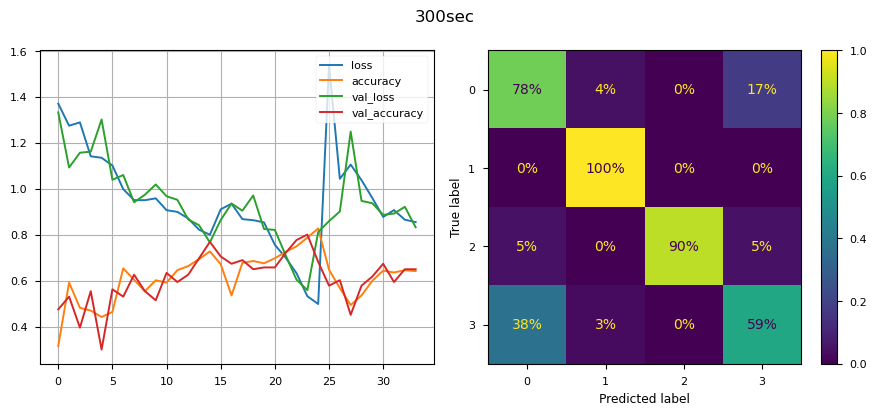

4/4 [==============================] - 0s 52ms/step - loss: 0.5839 - accuracy: 0.8000


 60% 6/10 [03:13<02:46, 41.59s/it]

Test Loss: 0.5839419364929199
Test Accuracy: 0.800000011920929
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3972 - accuracy: 0.2335
Epoch 1: val_accuracy improved from inf to 0.23810, saving model to results/lstm/lstm_360sec.h5
4/4 [==============================] - 3s 534ms/step - loss: 1.3972 - accuracy: 0.2335 - val_loss: 1.3616 - val_accuracy: 0.2381
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.3230 - accuracy: 0.3134
Epoch 2: val_accuracy did not improve from 0.23810
4/4 [==============================] - 2s 474ms/step - loss: 1.3230 - accuracy: 0.3134 - val_loss: 2.0876 - val_accuracy: 0.3730
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.5165 - accuracy: 0.4371
Epoch 3: val_accuracy did not improve from 0.23810
4/4 [==============================] - 2s 478ms/step - loss: 1.5165 - accuracy: 0.4371 - val_loss: 1.2121 - val_accuracy: 0.4683
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.1535

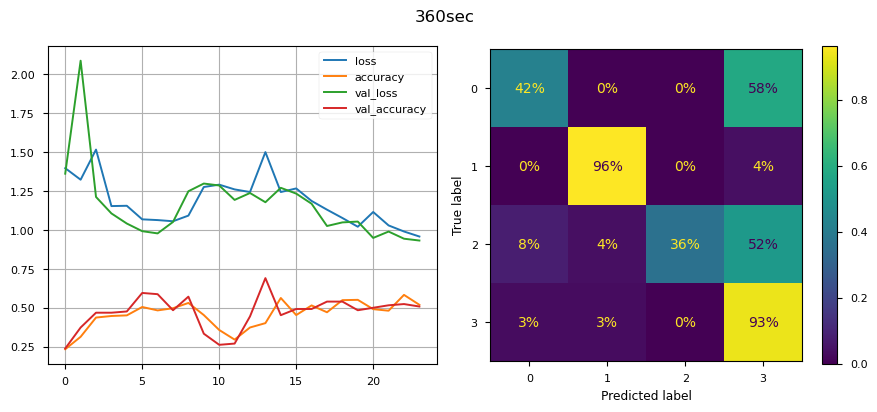

4/4 [==============================] - 0s 71ms/step - loss: 1.1496 - accuracy: 0.7000


 70% 7/10 [04:00<02:09, 43.21s/it]

Test Loss: 1.149583101272583
Test Accuracy: 0.699999988079071
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3845 - accuracy: 0.2660
Epoch 1: val_accuracy improved from inf to 0.20635, saving model to results/lstm/lstm_420sec.h5
4/4 [==============================] - 4s 593ms/step - loss: 1.3845 - accuracy: 0.2660 - val_loss: 1.4099 - val_accuracy: 0.2063
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.8613 - accuracy: 0.3660
Epoch 2: val_accuracy did not improve from 0.20635
4/4 [==============================] - 2s 539ms/step - loss: 1.8613 - accuracy: 0.3660 - val_loss: 1.2906 - val_accuracy: 0.4206
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.3071 - accuracy: 0.3300
Epoch 3: val_accuracy did not improve from 0.20635
4/4 [==============================] - 2s 541ms/step - loss: 1.3071 - accuracy: 0.3300 - val_loss: 1.3570 - val_accuracy: 0.2381
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.3475 

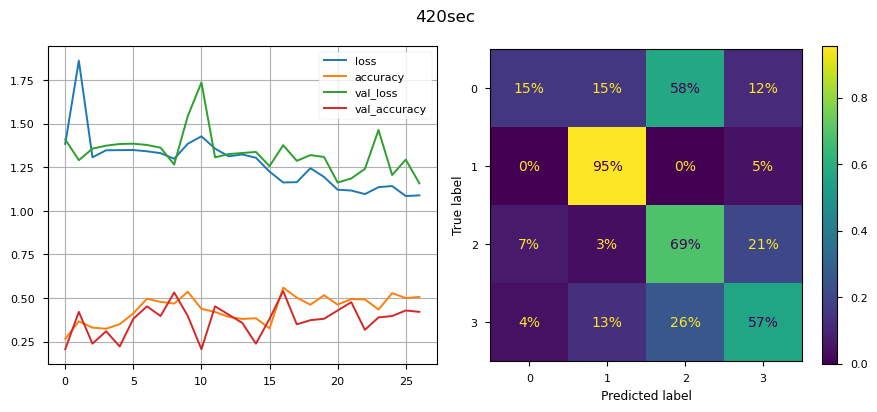

4/4 [==============================] - 0s 64ms/step - loss: 1.1890 - accuracy: 0.5800


 80% 8/10 [05:00<01:37, 48.60s/it]

Test Loss: 1.1890196800231934
Test Accuracy: 0.5799999833106995
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3765 - accuracy: 0.3000
Epoch 1: val_accuracy improved from inf to 0.40000, saving model to results/lstm/lstm_480sec.h5
4/4 [==============================] - 4s 701ms/step - loss: 1.3765 - accuracy: 0.3000 - val_loss: 1.3026 - val_accuracy: 0.4000
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.8293 - accuracy: 0.3920
Epoch 2: val_accuracy did not improve from 0.40000
4/4 [==============================] - 2s 595ms/step - loss: 1.8293 - accuracy: 0.3920 - val_loss: 1.2882 - val_accuracy: 0.4800
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.3312 - accuracy: 0.3700
Epoch 3: val_accuracy improved from 0.40000 to 0.38400, saving model to results/lstm/lstm_480sec.h5
4/4 [==============================] - 2s 646ms/step - loss: 1.3312 - accuracy: 0.3700 - val_loss: 1.3324 - val_accuracy: 0.3840
Epoch 4/100
4/4 [======

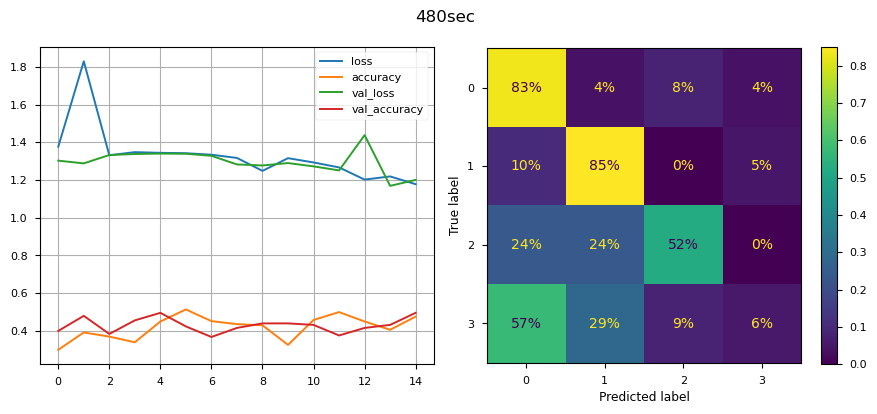

4/4 [==============================] - 0s 76ms/step - loss: 1.3519 - accuracy: 0.5000


 90% 9/10 [05:40<00:45, 45.76s/it]

Test Loss: 1.3519389629364014
Test Accuracy: 0.5
Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 1.3919 - accuracy: 0.2420
Epoch 1: val_accuracy improved from inf to 0.19200, saving model to results/lstm/lstm_540sec.h5
4/4 [==============================] - 4s 749ms/step - loss: 1.3919 - accuracy: 0.2420 - val_loss: 1.4111 - val_accuracy: 0.1920
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.3140
Epoch 2: val_accuracy did not improve from 0.19200
4/4 [==============================] - 3s 697ms/step - loss: 1.3580 - accuracy: 0.3140 - val_loss: 1.3560 - val_accuracy: 0.3520
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 1.7701 - accuracy: 0.3640
Epoch 3: val_accuracy did not improve from 0.19200
4/4 [==============================] - 3s 727ms/step - loss: 1.7701 - accuracy: 0.3640 - val_loss: 1.3508 - val_accuracy: 0.3680
Epoch 4/100
4/4 [==============================] - ETA: 0s - loss: 1.3318 - accuracy: 0

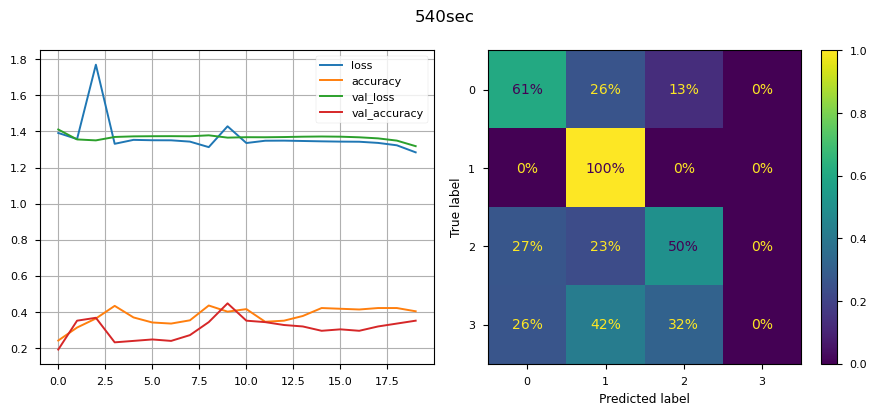

4/4 [==============================] - 0s 95ms/step - loss: 1.3072 - accuracy: 0.5700


100% 10/10 [06:37<00:00, 39.80s/it]

Test Loss: 1.3072419166564941
Test Accuracy: 0.5699999928474426


In [29]:
analysis_seconds = [30, 60*1, 60*2, 60*3, 60*4, 60*5, 60*6, 60*7, 60*8, 60*9]

for sec in tqdm(analysis_seconds[:]):
    analysis_time = int(sec) # seconds
    df_min = pd.read_hdf(HDF_DIR/'1_sec_data.h5', f'/{analysis_time}sec/X_sensor')
    df_min_scaled = df_min.apply(minmax_scale)
#     df_min_scaled.info()
    X = df_min_scaled.values.reshape(-1, analysis_time, 6)

    
    y_voc =  pd.read_hdf(HDF_DIR/'1_sec_data.h5', f'/{analysis_time}sec/y_voc')
    y_voc_onehot =  pd.read_hdf(HDF_DIR/'1_sec_data.h5', f'/{analysis_time}sec/y_voc_onehot')
    y_voc_encoded = LabelEncoder().fit_transform(y_voc)
#     print(X.shape, y_voc.shape, y_voc_onehot.shape, y_voc_encoded.shape)
    X, y_onehot, y_voc, y_voc_encoded = shuffle(X, y_voc_onehot, y_voc, y_voc_encoded)
    
    test_size = 100
    train_size = X.shape[0]-test_size
    
    X_train, y_train = X[:train_size], y_onehot[:train_size]
    X_test, y_test = X[train_size:], y_onehot[train_size:]
    X_train.shape, X_test.shape
    
    K.clear_session()
    
    n_features = 6
    output_size = 4
    lstm_units = analysis_time
    dense_units = 6
    rnn = Sequential([
        LSTM(units=lstm_units,
             dropout=.1,
             recurrent_dropout=.1,
             input_shape=(analysis_time, n_features), 
             name='LSTM',
             return_sequences=False),
        Dense(dense_units, name='FC'),
        Dense(output_size, name='Output',  activation="softmax")])
    
    rnn.compile(loss="categorical_crossentropy", 
                metrics=['accuracy'], 
                optimizer="adam")
    
    lstm_path = (RESULT_DIR / f'lstm/lstm_{analysis_time}sec.h5').as_posix()

    checkpointer = ModelCheckpoint(filepath=lstm_path,
                                   verbose=1,
                                   monitor='val_accuracy',
#                                    monitor='accuarcy',
                                   mode='min',
                                   save_best_only=True)
    
    early_stopping = EarlyStopping(
#                                monitor='val_loss',
                               monitor='val_accuracy',
                               patience=10,
                               restore_best_weights=True)
    
    result = rnn.fit(X_train,
                     y_train,
                     epochs=100,
                     batch_size=128,
                     shuffle=False,
    #                  validation_data=(X_test, y_test),
                     validation_split=0.2,
                     callbacks=[early_stopping, checkpointer],
                     verbose=1
                    )
    
    y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    test_mae = mean_absolute_error(y_pred, y_test)
    history = pd.DataFrame(result.history)
    
    # Confusion Matrix 계산
#     cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
    
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(history, label=history.columns)
    ax1.legend(loc='upper right')
    ax1.grid(True)

    # Confusion Matrix 시각화
#     plt.rc('font', size=10)
    ax2 = fig.add_subplot(1, 2, 2)
    ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), 
                                            y_pred_classes, 
                                            ax=ax2,
                                            normalize="true", 
                                            values_format=".0%")

    fig.suptitle(f'{analysis_time}sec')
    plt.tight_layout()
    plt.show()
    
    # 모델 평가
    loss, accuracy = rnn.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

In [17]:
# 레이블 인코딩
encoder = LabelEncoder()
y_voc_encoded = encoder.fit_transform(y_voc)
y_voc_encoded.shape

(728,)

In [18]:
X, y_onehot, y_voc, y_voc_encoded = shuffle(X, y_voc_onehot, y_voc, y_voc_encoded)

In [19]:
test_size = 100
train_size = X.shape[0]-test_size

In [20]:
X_train, y_train = X[:train_size], y_onehot[:train_size]
X_test, y_test = X[train_size:], y_onehot[train_size:]
X_train.shape, X_test.shape

((628, 60, 6), (100, 60, 6))

In [21]:
# y_test

## Define Model Architecture

In [22]:
K.clear_session()

In [23]:
n_features = 6
output_size = 4

In [24]:
lstm_units = analysis_time
dense_units = 6

In [25]:
rnn = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(analysis_time, n_features), 
         name='LSTM',
         return_sequences=False),
    Dense(dense_units, name='FC'),
    Dense(output_size, name='Output',  activation="softmax")
])

2024-03-19 17:06:41.623262: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 17:06:41.624804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 17:06:41.625026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-19 17:06:41.625197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [26]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 60)                16080     
                                                                 
 FC (Dense)                  (None, 6)                 366       
                                                                 
 Output (Dense)              (None, 4)                 28        
                                                                 
Total params: 16,474
Trainable params: 16,474
Non-trainable params: 0
_________________________________________________________________


In [27]:
# rnn.compile(loss='mae', optimizer='RMSProp')

In [28]:
# rnn.compile(loss='binary_crossentropy', optimizer='adam')

In [29]:
rnn.compile(loss="categorical_crossentropy"
              , metrics=['accuracy']
              , optimizer="adam")

## Train the Model

In [30]:
lstm_path = (RESULT_DIR / f'lstm/lstm_{analysis_time}sec.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_accuracy',
#                                monitor='accuarcy',
                               mode='min',
                               save_best_only=True)

In [31]:
early_stopping = EarlyStopping(
#                                monitor='val_loss',
                               monitor='val_accuracy',
                               patience=20,
                               restore_best_weights=True)

In [32]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=128,
                 shuffle=False,
#                  validation_data=(X_test, y_test),
                 validation_split=0.2,
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100


2024-03-19 17:06:43.831121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-19 17:06:43.871439: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7e5e3800c3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-19 17:06:43.871461: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-03-19 17:06:43.876696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-19 17:06:43.972312: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - ETA: 0s - loss: 1.3560 - accuracy: 0.2261
Epoch 1: val_accuracy improved from inf to 0.24000, saving model to results/lstm/lstm_1.h5
5/5 [==============================] - 3s 121ms/step - loss: 1.3560 - accuracy: 0.2261 - val_loss: 1.3259 - val_accuracy: 0.2400
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.2532
Epoch 2: val_accuracy did not improve from 0.24000
5/5 [==============================] - 0s 98ms/step - loss: 1.2922 - accuracy: 0.2532 - val_loss: 1.2758 - val_accuracy: 0.2400
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.2263 - accuracy: 0.4013
Epoch 3: val_accuracy did not improve from 0.24000
5/5 [==============================] - 1s 105ms/step - loss: 1.2263 - accuracy: 0.4013 - val_loss: 1.1950 - val_accuracy: 0.6100
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 1.1295 - accuracy: 0.6831
Epoch 4: val_accuracy did not improve from 0.24000
5/5 [=====

Epoch 31/100
5/5 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9777
Epoch 31: val_accuracy did not improve from 0.24000
5/5 [==============================] - 1s 101ms/step - loss: 0.0893 - accuracy: 0.9777 - val_loss: 0.1854 - val_accuracy: 0.9700
Epoch 32/100
5/5 [==============================] - ETA: 0s - loss: 0.0829 - accuracy: 0.9729
Epoch 32: val_accuracy did not improve from 0.24000
5/5 [==============================] - 0s 85ms/step - loss: 0.0829 - accuracy: 0.9729 - val_loss: 0.1596 - val_accuracy: 0.9600
Epoch 33/100
5/5 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9777
Epoch 33: val_accuracy did not improve from 0.24000
5/5 [==============================] - 1s 110ms/step - loss: 0.0862 - accuracy: 0.9777 - val_loss: 0.1548 - val_accuracy: 0.9700
Epoch 34/100
5/5 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9809
Epoch 34: val_accuracy did not improve from 0.24000
5/5 [=========================

## Evaluate the Results

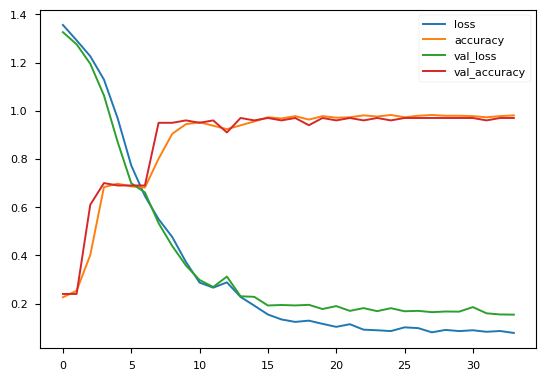

In [33]:
pd.DataFrame(result.history).plot();

In [34]:
y_test.columns

Index(['Acetic', 'Benzaldehyde', 'DPG', 'Keras'], dtype='object')

In [35]:
y_pred = pd.DataFrame(rnn.predict(X_test), 
                      columns=y_test.columns, 
                      index=y_test.index
                     )
y_pred.info()

4/4 [==============================] - 0s 10ms/step
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 592 to 102
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Acetic        100 non-null    float32
 1   Benzaldehyde  100 non-null    float32
 2   DPG           100 non-null    float32
 3   Keras         100 non-null    float32
dtypes: float32(4)
memory usage: 2.3 KB


In [36]:
# 예측 결과를 가장 높은 확률을 가진 클래스로 변환
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

array([3, 2, 0, 0, 2, 0, 3, 3, 0, 0, 3, 0, 2, 2, 1, 1, 0, 1, 1, 1, 2, 2,
       3, 1, 1, 0, 3, 2, 2, 0, 3, 2, 0, 3, 3, 3, 1, 0, 2, 2, 2, 2, 0, 1,
       3, 1, 1, 0, 1, 3, 2, 1, 0, 3, 3, 2, 3, 2, 1, 3, 3, 3, 1, 2, 3, 2,
       0, 2, 3, 1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 3, 0, 3, 0, 2, 0, 2,
       1, 1, 2, 0, 3, 0, 3, 0, 0, 1, 2, 0])

In [37]:
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)

0.06358166150428587


In [38]:
# 모델 평가
loss, accuracy = rnn.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 [==============================] - 0s 13ms/step - loss: 0.2303 - accuracy: 0.9700
Test Loss: 0.23034435510635376
Test Accuracy: 0.9700000286102295


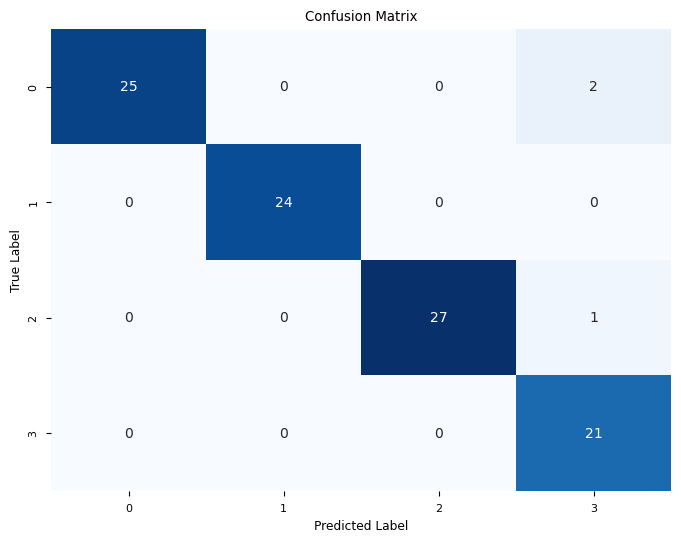

In [39]:
# Confusion Matrix 계산
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Method_02

## RF

In [40]:
# RandomForestClassifier 모델 생성
# model = RandomForestClassifier()

In [41]:
# # VOC_CYCLE을 제외한 모든 열을 features로 사용
# df_sensors = df[available_sensors]
# df_voc = df['VOC']

In [42]:
# df_sensors

In [43]:
# rows_with_null = df_sensors[df_sensors.isnull().any(axis=1)]
# rows_with_null

In [44]:
# # 모델 훈련
# model.fit(df_sensors[:200000], df_voc[:200000])

In [45]:
# # 변수 중요도 출력
# print("Feature Importance:")
# for feature, importance in zip(df_sensors.columns, model.feature_importances_):
#     print(f"{feature}: {importance}")

In [46]:
# baseline_accuracy = model.score(df_sensors[200000:], df_voc[200000:])
# baseline_accuracy